# Test Statistics Analysis

This notebook analyzes the test results from `data/tests/` to show which model was how successful across different benchmarks.

In [1]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## Load All Test Results

In [2]:
def load_test_results(tests_dir: Path) -> list[dict]:
    """Load all test results from the tests directory."""
    results = []
    
    # Find all test JSONL files recursively
    for jsonl_file in tests_dir.rglob("tests-*.jsonl"):
        with open(jsonl_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    record = json.loads(line)
                    results.append(record)
    
    return results

# Load all results
tests_dir = Path("../data/tests")
results = load_test_results(tests_dir)
print(f"Loaded {len(results)} test results")

Loaded 2855 test results


## Create DataFrame and Clean Model Names

In [3]:
# Create DataFrame
df = pd.DataFrame(results)

# Clean model names (extract just the model name without provider)
def clean_model_name(model_name: str) -> str:
    """Extract clean model name from full model identifier."""
    if '/' in model_name:
        return model_name.split('/')[-1]
    return model_name

df['model_short'] = df['model_name'].apply(clean_model_name)

print(f"\nDataFrame shape: {df.shape}")
print(f"\nBenchmarks: {df['benchmark'].unique().tolist()}")
print(f"\nModels: {df['model_short'].unique().tolist()}")
df.head()


DataFrame shape: (2855, 8)

Benchmarks: ['mbpp', 'ds1000', 'humaneval']

Models: ['gpt-5', 'deepseek-chat-v3-0324', 'claude-haiku-4.5', 'gemini-2.5-flash', 'grok-4-fast']


,benchmark,task_id,model_name,num_tests,num_passed,passed,errors,model_short
0,mbpp,70,openai/gpt-5,3,3,True,[],gpt-5
1,mbpp,18,openai/gpt-5,3,3,True,[],gpt-5
2,mbpp,83,openai/gpt-5,3,0,False,"[AssertionError: , AssertionError: , Assertion...",gpt-5
3,mbpp,17,openai/gpt-5,3,3,True,[],gpt-5
4,mbpp,19,openai/gpt-5,3,3,True,[],gpt-5


## Overall Statistics by Model

In [4]:
# Aggregate statistics by model
model_stats = df.groupby('model_short').agg(
    total_tasks=('passed', 'count'),
    tasks_passed=('passed', 'sum'),
    total_tests=('num_tests', 'sum'),
    tests_passed=('num_passed', 'sum')
).reset_index()

model_stats['task_pass_rate'] = (model_stats['tasks_passed'] / model_stats['total_tasks'] * 100).round(2)
model_stats['test_pass_rate'] = (model_stats['tests_passed'] / model_stats['total_tests'] * 100).round(2)

# Sort by task pass rate
model_stats = model_stats.sort_values('task_pass_rate', ascending=False)

print("Overall Model Performance:")
model_stats

Overall Model Performance:


,model_short,total_tasks,tasks_passed,total_tests,tests_passed,task_pass_rate,test_pass_rate
3,gpt-5,571,439,1110,862,76.88,77.66
4,grok-4-fast,571,415,1110,827,72.68,74.50
1,deepseek-chat-v3-0324,571,406,1110,835,71.10,75.23
0,claude-haiku-4.5,571,385,1110,794,67.43,71.53
2,gemini-2.5-flash,571,385,1110,798,67.43,71.89


## Statistics by Model and Benchmark

In [5]:
# Aggregate statistics by model and benchmark
benchmark_stats = df.groupby(['benchmark', 'model_short']).agg(
    total_tasks=('passed', 'count'),
    tasks_passed=('passed', 'sum'),
    total_tests=('num_tests', 'sum'),
    tests_passed=('num_passed', 'sum')
).reset_index()

benchmark_stats['task_pass_rate'] = (benchmark_stats['tasks_passed'] / benchmark_stats['total_tasks'] * 100).round(2)
benchmark_stats['test_pass_rate'] = (benchmark_stats['tests_passed'] / benchmark_stats['total_tests'] * 100).round(2)

print("Performance by Benchmark and Model:")
benchmark_stats.sort_values(['benchmark', 'task_pass_rate'], ascending=[True, False])

Performance by Benchmark and Model:


,benchmark,model_short,total_tasks,tasks_passed,total_tests,tests_passed,task_pass_rate,test_pass_rate
3,ds1000,gpt-5,150,91,170,106,60.67,62.35
4,ds1000,grok-4-fast,150,82,170,99,54.67,58.24
1,ds1000,deepseek-chat-v3-0324,150,72,170,88,48.00,51.76
2,ds1000,gemini-2.5-flash,150,70,170,86,46.67,50.59
0,ds1000,claude-haiku-4.5,150,54,170,69,36.00,40.59
8,humaneval,gpt-5,164,157,164,157,95.73,95.73
9,humaneval,grok-4-fast,164,154,164,154,93.90,93.90
5,humaneval,claude-haiku-4.5,164,152,164,152,92.68,92.68
6,humaneval,deepseek-chat-v3-0324,164,147,164,147,89.63,89.63
7,humaneval,gemini-2.5-flash,164,133,164,133,81.10,81.10


## Pivot Table: Task Pass Rate by Model and Benchmark

In [6]:
# Create pivot table for task pass rates
pivot_tasks = benchmark_stats.pivot(index='model_short', columns='benchmark', values='task_pass_rate')

# Add overall pass rate
pivot_tasks['Overall'] = model_stats.set_index('model_short')['task_pass_rate']

# Sort by overall pass rate
pivot_tasks = pivot_tasks.sort_values('Overall', ascending=False)

print("Task Pass Rate (%) by Model and Benchmark:")
pivot_tasks.style.format("{:.1f}%").background_gradient(cmap='RdYlGn', vmin=0, vmax=100)

Task Pass Rate (%) by Model and Benchmark:


benchmark,ds1000,humaneval,mbpp,Overall
model_short,,,,
gpt-5,60.7%,95.7%,74.3%,76.9%
grok-4-fast,54.7%,93.9%,69.7%,72.7%
deepseek-chat-v3-0324,48.0%,89.6%,72.8%,71.1%
claude-haiku-4.5,36.0%,92.7%,69.7%,67.4%
gemini-2.5-flash,46.7%,81.1%,70.8%,67.4%


## Visualization: Task Pass Rate by Model

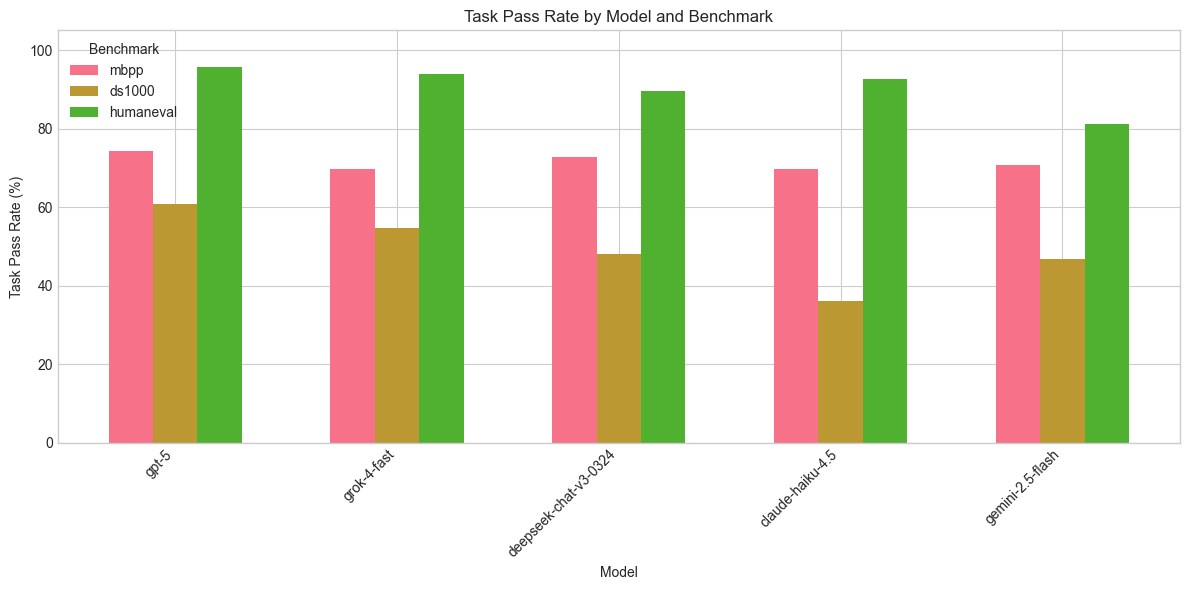

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for grouped bar chart
benchmarks = df['benchmark'].unique()
models = model_stats['model_short'].tolist()
x = range(len(models))
width = 0.2

for i, benchmark in enumerate(benchmarks):
    benchmark_data = benchmark_stats[benchmark_stats['benchmark'] == benchmark]
    rates = [benchmark_data[benchmark_data['model_short'] == m]['task_pass_rate'].values[0] 
             if m in benchmark_data['model_short'].values else 0 
             for m in models]
    ax.bar([xi + i * width for xi in x], rates, width, label=benchmark)

ax.set_xlabel('Model')
ax.set_ylabel('Task Pass Rate (%)')
ax.set_title('Task Pass Rate by Model and Benchmark')
ax.set_xticks([xi + width for xi in x])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(title='Benchmark')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

## Visualization: Heatmap of Pass Rates

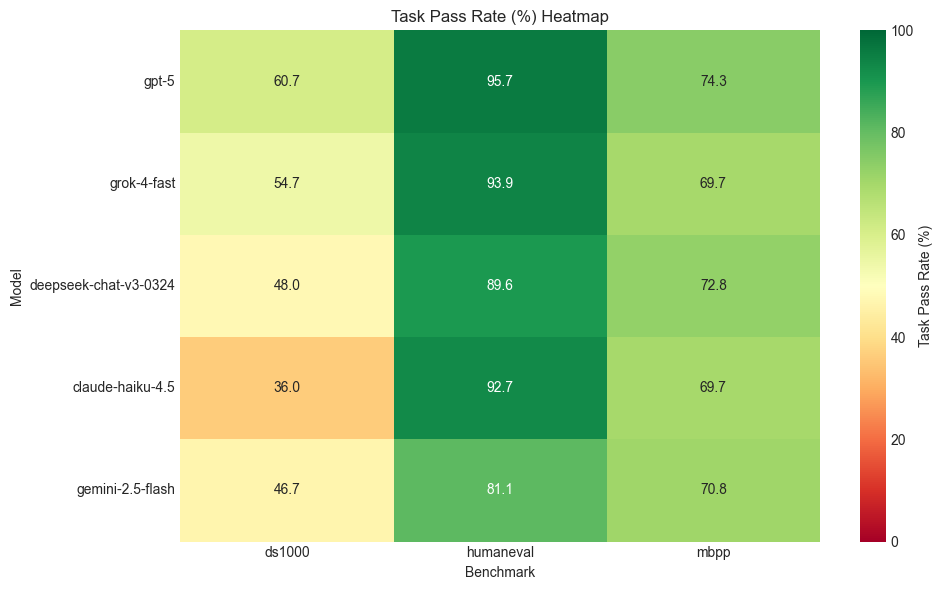

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create heatmap
heatmap_data = pivot_tasks.drop(columns='Overall', errors='ignore')

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    vmin=0,
    vmax=100,
    ax=ax,
    cbar_kws={'label': 'Task Pass Rate (%)'}
)

ax.set_title('Task Pass Rate (%) Heatmap')
ax.set_xlabel('Benchmark')
ax.set_ylabel('Model')

plt.tight_layout()
plt.show()

## Error Analysis

In [9]:
# Analyze failed tasks
failed_df = df[df['passed'] == False].copy()

# Count error types
def extract_error_type(errors: list) -> str:
    """Extract the type of error from the error list."""
    if not errors:
        return 'Unknown'
    error = errors[0] if isinstance(errors, list) else errors
    # Extract error type (e.g., AssertionError, SyntaxError)
    for err_type in ['TimeoutError', 'SyntaxError', 'AssertionError', 'NameError', 'TypeError', 'SetupError']:
        if err_type in str(error):
            return err_type
    return 'Other'

failed_df['error_type'] = failed_df['errors'].apply(extract_error_type)

# Count by model and error type
error_stats = failed_df.groupby(['model_short', 'error_type']).size().unstack(fill_value=0)

print(f"\nFailed Tasks: {len(failed_df)}")
print("\nError Types by Model:")
error_stats


Failed Tasks: 825

Error Types by Model:


error_type,AssertionError,NameError,Other,SetupError,SyntaxError,TimeoutError,TypeError
model_short,,,,,,,
claude-haiku-4.5,138,1,19,0,7,1,20
deepseek-chat-v3-0324,118,2,23,0,0,0,22
gemini-2.5-flash,118,3,19,14,9,1,22
gpt-5,71,17,28,0,4,0,12
grok-4-fast,107,0,24,0,0,1,24


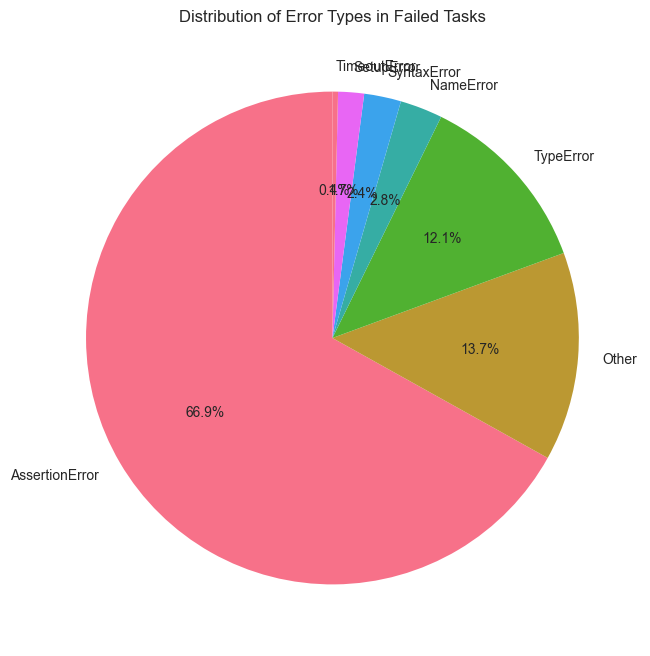

In [10]:
# Pie chart of error distribution
error_counts = failed_df['error_type'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(error_counts.values, labels=error_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Error Types in Failed Tasks')
plt.show()

## Summary Table

In [11]:
# Create a comprehensive summary table
summary = model_stats[['model_short', 'total_tasks', 'tasks_passed', 'task_pass_rate', 'test_pass_rate']].copy()
summary.columns = ['Model', 'Total Tasks', 'Tasks Passed', 'Task Pass Rate (%)', 'Test Pass Rate (%)']

# Add rank
summary['Rank'] = range(1, len(summary) + 1)
summary = summary[['Rank', 'Model', 'Total Tasks', 'Tasks Passed', 'Task Pass Rate (%)', 'Test Pass Rate (%)']]

print("\n" + "="*80)
print("FINAL SUMMARY: Model Performance Ranking")
print("="*80)
summary.to_string(index=False)


FINAL SUMMARY: Model Performance Ranking


' Rank                 Model  Total Tasks  Tasks Passed  Task Pass Rate (%)  Test Pass Rate (%)\n    1                 gpt-5          571           439               76.88               77.66\n    2           grok-4-fast          571           415               72.68               74.50\n    3 deepseek-chat-v3-0324          571           406               71.10               75.23\n    4      claude-haiku-4.5          571           385               67.43               71.53\n    5      gemini-2.5-flash          571           385               67.43               71.89'

In [12]:
# Display styled summary
summary.style.format({
    'Task Pass Rate (%)': '{:.2f}%',
    'Test Pass Rate (%)': '{:.2f}%'
}).hide(axis='index').background_gradient(
    subset=['Task Pass Rate (%)', 'Test Pass Rate (%)'],
    cmap='RdYlGn',
    vmin=0,
    vmax=100
)

Rank,Model,Total Tasks,Tasks Passed,Task Pass Rate (%),Test Pass Rate (%)
1,gpt-5,571,439,76.88%,77.66%
2,grok-4-fast,571,415,72.68%,74.50%
3,deepseek-chat-v3-0324,571,406,71.10%,75.23%
4,claude-haiku-4.5,571,385,67.43%,71.53%
5,gemini-2.5-flash,571,385,67.43%,71.89%
